In [ ]:
import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

2025-04-26 20:31:28.864640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745699489.054854      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745699489.108942      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import pandas as pd
from datasets import load_dataset

# Завантаження датасету
dataset = load_dataset('mavinsao/reddit-mental-illness-82')
df_tr = dataset['train'].to_pandas()
df_val = dataset['validation'].to_pandas()
df_ts = dataset['test'].to_pandas()
df = pd.concat([df_tr, df_val, df_ts], axis=0, ignore_index=True)

# Перетворення тексту на нижній регістр
df['text'] = df['text'].str.lower()

# Фільтрація рядків за наявністю ключових слів
keywords = [
    "think i have", "i think i have", "i think it might be", "i think i could have",
    "might have", "i might have", "might be", "feel like i have", "i feel like i have",
    "feels like i have", "self-diagnose", "self-diagnosed", "i've self-diagnosed",
    "unsure if i have", "i'm unsure if", "unsure if this is", "wonder if i have",
    "i wonder if i have", "wonder if it's", "symptoms of", "i have symptoms of",
    "experiencing symptoms of", "suspect i have", "i suspect i have", "i suspect it's",
    "probably have", "i probably have", "i think i probably have", "could be", "it could be",
    "seems like i have", "it seems like i have", "it seems like", "not diagnosed but",
    "i am not diagnosed but", "i haven't been diagnosed but"
]

df = df[~df['text'].str.contains('|'.join(keywords), case=False, na=False)]

# Розбиття тексту на заголовок і основний текст
def split_text(row):
    if ':' in row:
        parts = row.split(':', 1)
        return parts[0].strip(), parts[1].strip()
    return None, row.strip()

df[['title', 'main_text']] = df['text'].apply(split_text).apply(pd.Series)

# Перевірка результату
print(df[['title', 'main_text', 'label']])


README.md:   0%|          | 0.00/755 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/24.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5264 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

                                                   title  \
0                              fantasizing about your fp   
1      this is a support subreddit for people with a ...   
2                        scared of my psychotic symptoms   
4      i feel like a sick animal that needs to be put...   
5      is constantly checking ocd subreddits a compul...   
...                                                  ...   
52637  i got diagnosed with pure o, and finding it di...   
52638                 where can i read up on propaganda?   
52639  need help "keeping thoughts straight," or, mai...   
52640  does anyone else feel like none of their exper...   
52641                         wish me luck at work today   

                                               main_text  label  
0      do you do it? what do you fantasize about? : w...      3  
1      it's not for posting how infuriating the uneve...      6  
2      i'm trying to keep reminding myself that what ...      2  
4      i had a 

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import spacy

# Функція очищення тексту
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    text = text.str.replace(r'\[.*?\]', '', regex=True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    text = text.str.replace(r'<.*?>+', '', regex=True)
    text = text.str.replace(r'\w*\d\w*', '', regex=True)
    return text

# Функція видалення стоп-слів
# custom_stopwords = {'ocd', 'anxiety', 'adhd', 'ptsd', 'bpd', 'depression', 'bipolar'}
custom_stopwords = {}
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(custom_stopwords)
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word.lower() not in stop_words))
    return text

# Функція лематизації
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

# Застосування функцій до обох стовпців
def process_text_columns(df, columns):
    for col in columns:
        # Очищення тексту
        df[col] = clean_text(df[col])
        # Видалення стоп-слів
        df[col] = remove_stopwords(df[col])
        # Видалення найчастіших слів
        delete = pd.Series(' '.join(df[col]).split()).value_counts()[-1000:]
        df[col] = df[col].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in delete))
        # Лематизація
        df[col] = df[col].apply(lemmatize_sentence)
    return df


df = pd.DataFrame(df)
# Застосування функцій до стовпців 'title' і 'main_text'
df = process_text_columns(df, ['title', 'main_text'])
print(df)


                                                    text  label  \
0      fantasizing about your fp: do you do it? what ...      3   
1      this is a support subreddit for people with a ...      6   
2      scared of my psychotic symptoms : i'm trying t...      2   
4      i feel like a sick animal that needs to be put...      4   
5      is constantly checking ocd subreddits a compul...      6   
...                                                  ...    ...   
52637  i got diagnosed with pure o, and finding it di...      6   
52638  where can i read up on propaganda? : i want to...      5   
52639  need help "keeping thoughts straight," or, mai...      0   
52640  does anyone else feel like none of their exper...      1   
52641  wish me luck at work today : oh god my anxiety...      1   

                                                   title  \
0                                           fantasize fp   
1                support subreddit people mental illness   
2              

In [ ]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 5.4 MB/s eta 0:00:0000:01
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0


In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split




# Об'єднання заголовку і основного тексту в один стовпець
df['text'] = df['title'].str.strip(':') + ' ' + df['main_text']
# df['text'] = df['main_text']
X = df['text']
y = df['label']

# Ініціалізація RandomUnderSampler для балансування класів
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Застосування undersampling
X_res, y_res = undersampler.fit_resample(X.values.reshape(-1, 1), y)
print("Розподіл класів після балансування:")
print(pd.Series(y_res).value_counts())
balanced_df = pd.DataFrame({
    'text': X_res.flatten(),
    'label': y_res
})

# Розбиття на тренувальний та тестовий набори після балансування
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)
print("\nРозподіл класів у тренувальному наборі:")
print(train_df['label'].value_counts())
print("\nРозподіл класів у тестовому наборі:")
print(test_df['label'].value_counts())


Розподіл класів після балансування:
label
0    4086
1    4086
2    4086
3    4086
4    4086
5    4086
6    4086
7    4086
Name: count, dtype: int64

Розподіл класів у тренувальному наборі:
label
5    3335
0    3296
1    3279
4    3264
6    3264
3    3260
2    3228
7    3224
Name: count, dtype: int64

Розподіл класів у тестовому наборі:
label
7    862
2    858
3    826
6    822
4    822
1    807
0    790
5    751
Name: count, dtype: int64


# **Ensemble *(deberta-v3-base* and *roberta*)**

---



In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

deberta_model_name = 'microsoft/deberta-v3-base'
roberta_model_name = 'roberta-base'

deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_model_name)
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)


def tokenize_data(texts, tokenizer, max_len):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")


max_len = 256
train_texts = train_df['text'].tolist()
test_texts = test_df['text'].tolist()

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
num_labels = len(label_encoder.classes_)

deberta_train_encodings = tokenize_data(train_texts, deberta_tokenizer, max_len)
deberta_test_encodings = tokenize_data(test_texts, deberta_tokenizer, max_len)

roberta_train_encodings = tokenize_data(train_texts, roberta_tokenizer, max_len)
roberta_test_encodings = tokenize_data(test_texts, roberta_tokenizer, max_len)

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

batch_size = 16

deberta_train_dataset = TextDataset(deberta_train_encodings, y_train)
deberta_test_dataset = TextDataset(deberta_test_encodings, y_test)

roberta_train_dataset = TextDataset(roberta_train_encodings, y_train)
roberta_test_dataset = TextDataset(roberta_test_encodings, y_test)

deberta_train_loader = DataLoader(deberta_train_dataset, batch_size=batch_size, shuffle=True)
deberta_test_loader = DataLoader(deberta_test_dataset, batch_size=batch_size, shuffle=False)

roberta_train_loader = DataLoader(roberta_train_dataset, batch_size=batch_size, shuffle=True)
roberta_test_loader = DataLoader(roberta_test_dataset, batch_size=batch_size, shuffle=False)

# Initialize
deberta_model = AutoModelForSequenceClassification.from_pretrained(deberta_model_name, num_labels=num_labels).to(device)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name, num_labels=num_labels).to(device)

deberta_optimizer = AdamW(deberta_model.parameters(), lr=2e-5)
roberta_optimizer = AdamW(roberta_model.parameters(), lr=2e-5)

epochs = 5

deberta_scheduler = get_linear_schedule_with_warmup(
    deberta_optimizer, num_warmup_steps=0, num_training_steps=len(deberta_train_loader) * epochs)

roberta_scheduler = get_linear_schedule_with_warmup(
    roberta_optimizer, num_warmup_steps=0, num_training_steps=len(roberta_train_loader) * epochs)

# Training
def train_model(model, train_loader, optimizer, scheduler, device, epochs, model_name="Model"):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for batch in tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == batch['labels']).sum().item()
            total_predictions += batch['labels'].size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions
        print(f"{model_name} - Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

train_model(deberta_model, deberta_train_loader, deberta_optimizer, deberta_scheduler, device, epochs, model_name="DeBERTa")
train_model(roberta_model, roberta_train_loader, roberta_optimizer, roberta_scheduler, device, epochs, model_name="RoBERTa")

# Evaluation function for ensembling
def evaluate_ensemble(models, test_loaders, device):
    for model in models:
        model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for deberta_batch, roberta_batch in tqdm(zip(*test_loaders), desc="Ensemble Evaluating", total=len(test_loaders[0])):
            deberta_batch = {k: v.to(device) for k, v in deberta_batch.items()}
            roberta_batch = {k: v.to(device) for k, v in roberta_batch.items()}

            deberta_outputs = models[0](**deberta_batch).logits
            roberta_outputs = models[1](**roberta_batch).logits

            # Soft voting
            avg_logits = (deberta_outputs + roberta_outputs) / 2
            preds = torch.argmax(avg_logits, dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(deberta_batch['labels'].cpu().numpy())

    return all_preds, all_labels

# Ensemble evaluation
y_test_pred, y_test_labels = evaluate_ensemble(
    [deberta_model, roberta_model],
    [deberta_test_loader, roberta_test_loader],
    device
)

print("Ensembled Model Evaluation:")
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test_labels, y_test_pred, target_names=label_encoder.classes_))


Using device: cuda


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
DeBERTa - Epoch 1/5: 100%|██████████| 1635/1635 [26:43<00:00,  1.02it/s]


DeBERTa - Epoch 1/5 - Loss: 0.9080, Accuracy: 0.6957


DeBERTa - Epoch 2/5: 100%|██████████| 1635/1635 [26:44<00:00,  1.02it/s]


DeBERTa - Epoch 2/5 - Loss: 0.5872, Accuracy: 0.8169


DeBERTa - Epoch 3/5: 100%|██████████| 1635/1635 [26:44<00:00,  1.02it/s]


DeBERTa - Epoch 3/5 - Loss: 0.4797, Accuracy: 0.8496


DeBERTa - Epoch 4/5: 100%|██████████| 1635/1635 [26:41<00:00,  1.02it/s]


DeBERTa - Epoch 4/5 - Loss: 0.3959, Accuracy: 0.8779


DeBERTa - Epoch 5/5: 100%|██████████| 1635/1635 [26:41<00:00,  1.02it/s]


DeBERTa - Epoch 5/5 - Loss: 0.3243, Accuracy: 0.9024


RoBERTa - Epoch 1/5: 100%|██████████| 1635/1635 [20:11<00:00,  1.35it/s]


RoBERTa - Epoch 1/5 - Loss: 0.7480, Accuracy: 0.7561


RoBERTa - Epoch 2/5: 100%|██████████| 1635/1635 [20:13<00:00,  1.35it/s]


RoBERTa - Epoch 2/5 - Loss: 0.5089, Accuracy: 0.8341


RoBERTa - Epoch 3/5: 100%|██████████| 1635/1635 [20:13<00:00,  1.35it/s]


RoBERTa - Epoch 3/5 - Loss: 0.3968, Accuracy: 0.8738


RoBERTa - Epoch 4/5: 100%|██████████| 1635/1635 [20:14<00:00,  1.35it/s]


RoBERTa - Epoch 4/5 - Loss: 0.2952, Accuracy: 0.9081


RoBERTa - Epoch 5/5: 100%|██████████| 1635/1635 [20:13<00:00,  1.35it/s]


RoBERTa - Epoch 5/5 - Loss: 0.2210, Accuracy: 0.9321


Ensemble Evaluating: 100%|██████████| 409/409 [03:48<00:00,  1.79it/s]

Ensembled Model Evaluation:
Test Accuracy: 0.8397


TypeError: object of type 'numpy.int64' has no len()

In [ ]:
print(classification_report(y_test_labels, y_test_pred, target_names=[str(c) for c in label_encoder.classes_]))


              precision    recall  f1-score   support

           0       0.90      0.87      0.88       790
           1       0.79      0.80      0.80       807
           2       0.83      0.79      0.81       858
           3       0.79      0.77      0.78       826
           4       0.71      0.80      0.75       822
           5       0.99      0.98      0.98       751
           6       0.89      0.88      0.88       822
           7       0.85      0.85      0.85       862

    accuracy                           0.84      6538
   macro avg       0.84      0.84      0.84      6538
weighted avg       0.84      0.84      0.84      6538



In [ ]:

deberta_weights_path = '/kaggle/working/deberta_model_weights.pth'
roberta_weights_path = '/kaggle/working/roberta_model_weights.pth'

deberta_fullmodel_path = '/kaggle/working/deberta_full_model.pt'
roberta_fullmodel_path = '/kaggle/working/roberta_full_model.pt'

torch.save(deberta_model.state_dict(), deberta_weights_path)
torch.save(roberta_model.state_dict(), roberta_weights_path)
torch.save(deberta_model, deberta_fullmodel_path)
torch.save(roberta_model, roberta_fullmodel_path)

print(f"DeBERTa weights saved to {deberta_weights_path}")
print(f"RoBERTa weights saved to {roberta_weights_path}")
print(f"DeBERTa full model saved to {deberta_fullmodel_path}")
print(f"RoBERTa full model saved to {roberta_fullmodel_path}")


DeBERTa weights saved to /kaggle/working/deberta_model_weights.pth
RoBERTa weights saved to /kaggle/working/roberta_model_weights.pth
DeBERTa full model saved to /kaggle/working/deberta_full_model.pt
RoBERTa full model saved to /kaggle/working/roberta_full_model.pt


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- 1. Завантажуємо обидві моделі ---
deberta_model = torch.load('/kaggle/working/deberta_full_model.pt')
roberta_model = torch.load('/kaggle/working/roberta_full_model.pt')

deberta_model.to(device)
roberta_model.to(device)

deberta_model.eval()
roberta_model.eval()

# --- 2. Завантажуємо токенайзери ---
deberta_tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')
roberta_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# --- 3. Функція для ансамблевого передбачення ---
def ensemble_predict(texts):
    # Tokenize тексти для обох моделей
    deberta_inputs = deberta_tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
    roberta_inputs = roberta_tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)

    with torch.no_grad():
        deberta_logits = deberta_model(**deberta_inputs).logits
        roberta_logits = roberta_model(**roberta_inputs).logits

        # Soft voting - середнє логітів
        avg_logits = (deberta_logits + roberta_logits) / 2

        preds = torch.argmax(avg_logits, dim=-1)

    predicted_labels = label_encoder.inverse_transform(preds.cpu().numpy())
    return predicted_labels

# --- 4. Приклад використання ---
texts = [
    # OCD
    "I can't leave the house without checking the door lock at least ten times. If I don't, I feel like something terrible will happen.",

    # Anxiety
    "My heart races even when I’m just thinking about going to a social event. I keep imagining the worst possible scenarios.",

    # ADHD
    "I start a task, then immediately get distracted by something else. I find it almost impossible to stay focused on anything for long.",

    # PTSD
    "Loud noises make me jump and flash me back to the accident. I can’t sleep properly and constantly feel on edge.",

# BPD (Borderline Personality Disorder)
    "I constantly feel emotions so intensely that it’s exhausting. One minute I feel like I am loved and valued, and the next I am completely convinced that everyone secretly hates me. Small arguments make me spiral out of control, and I fear abandonment so much that I sometimes push people away first, just to avoid the pain of losing them later.",

    # Depression
    "Every morning I wake up and feel a heavy weight on my chest. Even the simplest tasks like brushing my teeth or answering a message feel overwhelming. It's like there’s no point in anything I do. I isolate myself from friends because I don't want to be a burden, and sometimes I just lie in bed for hours staring at the ceiling, unable to move.",

    # Bipolar Disorder
    "There are weeks when I feel unstoppable — I barely sleep, take on too many projects, and feel like I’m destined for greatness. I talk quickly, come up with grand ideas, and feel an intense sense of euphoria. But then, without warning, the crash comes: I fall into deep sadness, lose all interest in my passions, and struggle even to get dressed or leave my house.",

    # Normal (Healthy State)
    "Lately, I’ve been feeling quite balanced. I enjoy spending time with my friends and family, and although there are small stresses at work, I can handle them without feeling overwhelmed. I find joy in little things like cooking dinner, taking walks in nature, and reading before bed. My emotions feel stable, and I generally feel satisfied with where I am in life."
]


predictions = ensemble_predict(texts)
print(predictions)


[6 1 0 7 3 4 4 3]


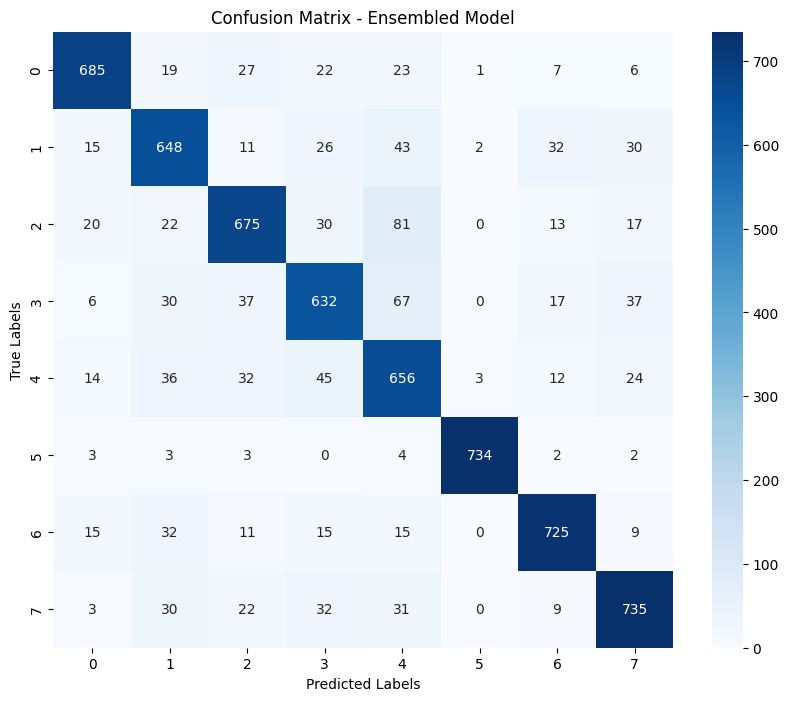

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Ensembled Model')
plt.show()


# **deberta-v3-base**

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW

from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_name = 'microsoft/deberta-v3-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(texts, tokenizer, max_len):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")

max_len = 256
train_encodings = tokenize_data(train_df['text'].tolist(), tokenizer, max_len)
test_encodings = tokenize_data(test_df['text'].tolist(), tokenizer, max_len)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_)).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * epochs)

# Training
def train_model(model, train_loader, optimizer, scheduler, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == batch['labels']).sum().item()
            total_predictions += batch['labels'].size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.4f}")

# Evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return all_preds, all_labels

train_model(model, train_loader, optimizer, scheduler, device, epochs)

y_test_pred, y_test_labels = evaluate_model(model, test_loader, device)
print("DeBERTa-v3 Model Evaluation:")
test_accuracy = accuracy_score(y_test_labels, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test_labels, y_test_pred))


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Epoch 1/5: 100%|██████████| 1635/1635 [27:42<00:00,  1.02s/it]


Epoch 1/5 - Loss: 0.9175, Training Accuracy: 0.6828


Epoch 2/5: 100%|██████████| 1635/1635 [27:58<00:00,  1.03s/it]


Epoch 2/5 - Loss: 0.5628, Training Accuracy: 0.8210


Epoch 3/5: 100%|██████████| 1635/1635 [27:58<00:00,  1.03s/it]


Epoch 3/5 - Loss: 0.4525, Training Accuracy: 0.8579


Epoch 4/5: 100%|██████████| 1635/1635 [27:59<00:00,  1.03s/it]


Epoch 4/5 - Loss: 0.3598, Training Accuracy: 0.8868


Epoch 5/5: 100%|██████████| 1635/1635 [27:58<00:00,  1.03s/it]


Epoch 5/5 - Loss: 0.2855, Training Accuracy: 0.9131


Evaluating: 100%|██████████| 409/409 [02:24<00:00,  2.83it/s]

DeBERTa-v3 Model Evaluation:
Test Accuracy: 0.8307
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       790
           1       0.77      0.80      0.78       807
           2       0.81      0.76      0.79       858
           3       0.79      0.74      0.77       826
           4       0.69      0.79      0.73       822
           5       0.99      0.98      0.99       751
           6       0.87      0.88      0.88       822
           7       0.86      0.85      0.86       862

    accuracy                           0.83      6538
   macro avg       0.84      0.83      0.83      6538
weighted avg       0.83      0.83      0.83      6538

